# Description
In this project, we use the data from kaggle competition [Toxic Comment Classification Challenge by Jigsaw](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data?select=train.csv.zip) and only use the training data. Then we have break this raw training data into train and test data and evaluate the model performances in test data.

The dataset is taken from wikipedia edit text and is classified as one of the following:

1. toxic
2. severe_toxic
3. obscene
4. threat
5. insult
6. identity_hate

This is a multi-label (not-multiclass) classification. One text row has six labels and exactly one label is 1 and other labels are 0.


References:
- https://colab.research.google.com/github/rap12391/transformers_multilabel_toxic/blob/master/toxic_multilabel.ipynb

# Load the Libraries

In [ ]:
import os
import sys
import time

time_start_notebook = time.time()

In [ ]:
%%capture
import os
import sys
ENV_COLAB = 'google.colab' in sys.modules

if ENV_COLAB:
    ## install modules
    !pip install transformers
    !pip install scikit-plot
    !pip install watermark


In [ ]:
# data science
import numpy as np
import pandas as pd
from tqdm import tqdm

# visualization
import seaborn as sns
sns.set(color_codes=True)
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# mixed
import os
import time
from pprint import pprint
import joblib
import pickle
from tqdm import tqdm, trange
from ast import literal_eval

# random state
SEED=100
np.random.seed(SEED)

# machine learning
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import f1_score, accuracy_score

# deep learning
import tensorflow as tf
from keras.preprocessing.sequence import pad_sequences
import torch
from torch.nn import BCEWithLogitsLoss, BCELoss
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import RandomSampler, SequentialSampler
import transformers
from transformers import *

# model eval
import scikitplot as skplt

# versions
import watermark
%load_ext watermark
%watermark -a "Bhishan Poudel" -d -v -m
print()
%watermark -iv

Bhishan Poudel 2020-12-02 

CPython 3.6.9
IPython 5.5.0

compiler   : GCC 8.4.0
system     : Linux
release    : 4.19.112+
machine    : x86_64
processor  : x86_64
CPU cores  : 2
interpreter: 64bit

tensorflow              2.3.0
transformers            4.0.0
matplotlib              3.2.2
transformers.file_utils 4.0.0
torch                   1.7.0+cu101
scikitplot              0.3.7
watermark               2.0.2
numpy                   1.18.5
sklearn                 0.22.2.post1
pandas                  1.1.4
joblib                  0.17.0
seaborn                 0.11.0



# Useful Functions

In [ ]:
def show_methods(obj, ncols=4,contains=None):
    lst = [i for i in dir(obj) if i[0]!='_' ]
    if contains is not None:
        lst = [i for i in lst if contains in i]
    df = pd.DataFrame(np.array_split(lst,ncols)).T.fillna('')
    return df

# GPU Testing

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla P100-PCIE-16GB'

## Load Training Data

In [ ]:
# %%capture
# !wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/train.csv.zip?raw=true
# !unzip train.csv.zip?raw=true

# !wget https://github.com/bhishanpdl/Datasets/blob/master/Projects/Jigsaw_Toxic_Comment_Classification/test.csv.zip?raw=true
# !unzip test.csv.zip?raw=true

In [ ]:
!ls

 bert_model_toxic		       test_data_loader
 classification_report_optimized.txt   train.csv
 classification_report.txt	      'train.csv.zip?raw=true'
 comparisons.csv		      'train.csv.zip?raw=true.1'
 sample_data			       train_data_loader
 test.csv			       validation_data_loader
'test.csv.zip?raw=true'		       valid_data_loader
'test.csv.zip?raw=true.1'


In [ ]:
df_train = pd.read_csv('train.csv')
df_train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,8d603d50affa1126,"""\nYes, aside, thank you for trying to answer ...",0,0,0,0,0,0
1,8fb3576937b9e0d0,March 2010 (UTC)\n\nThanks! and understood abo...,0,0,0,0,0,0
2,379440e04fb68e27,"""\n\n The Outfield \n\nHahaha - compassion is ...",0,0,0,0,0,0
3,6be4446aac8ae028,Opposition is a source of strength. I believe ...,0,0,0,0,0,0
4,1a2ff7ed958506a3,Please discontinue making those unsupported ch...,0,0,0,0,0,0


In [ ]:
col_text = 'comment_text'

In [ ]:
# unique text
df_train[col_text].nunique(), df_train.shape[0]

(127656, 127656)

In [ ]:
# null values
df_train.isnull().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [ ]:
cols_label = ['toxic', 'severe_toxic', 'obscene',
              'threat', 'insult', 'identity_hate']

In [ ]:
print('Count of 1 per label: \n', df_train[cols_label].sum(), '\n') 
print('Count of 0 per label: \n', df_train[cols_label].eq(0).sum())

Count of 1 per label: 
 toxic            12202
severe_toxic      1282
obscene           6782
threat             379
insult            6292
identity_hate     1136
dtype: int64 

Count of 0 per label: 
 toxic            115454
severe_toxic     126374
obscene          120874
threat           127277
insult           121364
identity_hate    126520
dtype: int64


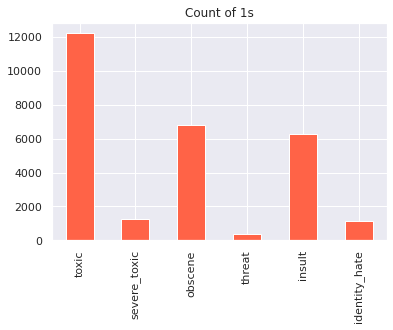

In [ ]:
df_train[cols_label].sum().plot.bar(title='Count of 1s',color='tomato');

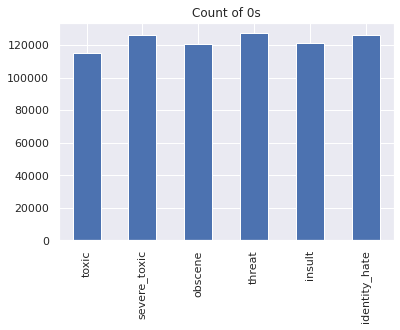

In [ ]:
df_train[cols_label].eq(0).sum().plot.bar(title='Count of 0s');

# Data Processing: Training Data

## Shuffle and create ohe column

In [ ]:
# shuffle data
df_train = df_train.sample(frac=1,random_state=SEED).reset_index(drop=True)

In [ ]:
col_ohe = 'one_hot_labels'
df_train[col_ohe] = df_train[cols_label].to_numpy().tolist()
df_train.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,815dac68f62b1e6a,"""\n\n Defenestration \n\nIt was previously rep...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,570a66d523877761,I am easily able to trace my lineage back to C...,0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
labels    = list(df_train[col_ohe].values)
list_text = list(df_train[col_text].values)

In [ ]:
# list_text[0]

## Load pretrained tokenizer

Transformers pretrained tokenizers

```python
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```


In [ ]:
# show_methods(transformers,3,contains='Tokenizer')

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(
    'bert-base-uncased',do_lower_case=True)

## Get Encodings from tokenizer

In [ ]:
%%time
max_length = 100 # choose about 100 for colab
encodings = tokenizer.batch_encode_plus(list_text,
                max_length=max_length,
                pad_to_max_length=True)

print('tokenizer outputs: ', encodings.keys())
 
# dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
# Wall time: 3min 28s

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


tokenizer outputs:  dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
CPU times: user 3min 17s, sys: 468 ms, total: 3min 18s
Wall time: 3min 18s


In [ ]:
input_ids       = encodings['input_ids']
token_type_ids  = encodings['token_type_ids']
attention_masks = encodings['attention_mask']

## Find unique ohe indices

In [ ]:
# Identifying indices of 'one_hot_labels' entries that only occur once
# This will allow us to stratify split our training data later

label_counts = df_train[col_ohe].astype(str).value_counts()
one_freq = label_counts[label_counts==1].keys()

cond = df_train[col_ohe].astype(str).isin(one_freq)
one_freq_idxs = df_train[cond].index
one_freq_idxs = sorted(list(one_freq_idxs), reverse=True)

print('df_train label indices with only one instance: ', one_freq_idxs)

df_train label indices with only one instance:  [113097, 57059, 7039]


In [ ]:
# Gathering single instance inputs to force
# into the training set after stratified split

one_freq_input_ids       = [input_ids.pop(i)       for i in one_freq_idxs]
one_freq_token_types     = [token_type_ids.pop(i)  for i in one_freq_idxs]
one_freq_attention_masks = [attention_masks.pop(i) for i in one_freq_idxs]
one_freq_labels          = [labels.pop(i)          for i in one_freq_idxs]

# Get train validation tensors

In [ ]:
%%time

# train valid split using stratify

train_inputs, valid_inputs,\
train_labels, valid_labels,\
train_token_types, valid_token_types,\
train_masks, valid_masks\
  = train_test_split(input_ids, labels, token_type_ids,attention_masks,
                    random_state=SEED,
                    test_size=0.10,
                    stratify = labels)

# Add one frequency data to train data
train_inputs.extend(one_freq_input_ids)
train_labels.extend(one_freq_labels)
train_masks.extend(one_freq_attention_masks)
train_token_types.extend(one_freq_token_types)

# Convert all of our data into torch tensors
train_inputs      = torch.tensor(train_inputs)
train_labels      = torch.tensor(train_labels)
train_masks       = torch.tensor(train_masks)
train_token_types = torch.tensor(train_token_types)

valid_inputs      = torch.tensor(valid_inputs)
valid_labels      = torch.tensor(valid_labels)
valid_masks       = torch.tensor(valid_masks)
valid_token_types = torch.tensor(valid_token_types)

CPU times: user 3.2 s, sys: 115 ms, total: 3.32 s
Wall time: 3.32 s


## Create DataLoader

In [ ]:
from torch.utils.data import (TensorDataset, DataLoader,
                              RandomSampler, SequentialSampler)

In [ ]:
# Select a batch size for training.
# For fine-tuning with XLNet, the authors recommend
# a batch size of 32, 48, or 128.
# We will use 32 here to avoid memory issues.
batch_size = 32


# Create an iterator of our data with torch DataLoader.
# This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data       = TensorDataset(train_inputs, train_masks,
                                 train_labels, train_token_types)
train_sampler    = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler,
                              batch_size=batch_size)

valid_data       = TensorDataset(valid_inputs, valid_masks,
                                 valid_labels, valid_token_types)
valid_sampler    = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler,
                              batch_size=batch_size)

In [ ]:
# # save data loaders
# torch.save(train_dataloader,'train_data_loader')
# torch.save(valid_dataloader,'valid_data_loader')

In [ ]:
# !ls

 bert_model_toxic		       test_data_loader
 classification_report_optimized.txt   train.csv
 classification_report.txt	      'train.csv.zip?raw=true'
 comparisons.csv		      'train.csv.zip?raw=true.1'
 sample_data			       train_data_loader
 test.csv			       validation_data_loader
'test.csv.zip?raw=true'		       valid_data_loader
'test.csv.zip?raw=true.1'


## Load the Model for Sequence Classification

```python
BERT:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True) 

XLNet:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased', do_lower_case=False) 

RoBERTa:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=False)
```

In [ ]:
# show_methods(transformers,contains='SequenceClassification',ncols=2)

In [ ]:
%%time
# Load classification model

num_labels = len(cols_label)
model = transformers.BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", num_labels=num_labels)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

CPU times: user 6.38 s, sys: 1.37 s, total: 7.76 s
Wall time: 8.27 s


## Choose Optimizer

Setting custom optimization parameters for the AdamW optimizer https://huggingface.co/transformers/main_classes/optimizer_schedules.html

In [ ]:
show_methods(transformers,3,contains='Adam')

,0,1,2
0,AdamW,AdamWeightDecay,


In [ ]:
# setting custom optimization parameters.
params_opt = list(model.named_parameters())

no_decay = ['bias', 'gamma', 'beta']


params_opt_group = [
    # non decay params
    {'params': [p for n, p in params_opt
                if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},

    # decay params
    {'params': [p for n, p in params_opt
                if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [ ]:
optimizer = transformers.AdamW(params_opt_group,lr=2e-5,correct_bias=True)
# optimizer = AdamW(model.parameters(),lr=2e-5)  # Default optimization

## Train Model

In [ ]:
%%time

from tqdm import trange

# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):

  # Training
  
  # train model
  model.train()

  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(b.to(device) for b in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch

    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()

    # # Forward pass for multiclass classification
    # outputs = model(b_input_ids, token_type_ids=None,
    #                  attention_mask=b_input_mask, labels=b_labels)
    # loss = outputs[0]
    # logits = outputs[1]

    # Forward pass for multilabel classification
    outputs = model(b_input_ids, token_type_ids=None,
                    attention_mask=b_input_mask)
    logits = outputs[0]
    loss_func = BCEWithLogitsLoss() 
    loss = loss_func(logits.view(-1,num_labels),
                     b_labels.type_as(logits).view(-1,num_labels))
    # loss_func = BCELoss() 
    # loss = loss_func(torch.sigmoid(logits.view(-1,num_labels)),
    #             b_labels.type_as(logits).view(-1,num_labels))
    train_loss_set.append(loss.item())    

    # Backward pass
    loss.backward()

    # Update parameters and take a step using the computed gradient
    optimizer.step()
    # scheduler.step()

    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))

###############################################################################

  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Variables to gather full output
  logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

  # Predict
  for i, batch in enumerate(valid_dataloader):
    batch = tuple(b.to(device) for b in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels, b_token_types = batch

    with torch.no_grad():
      # Forward pass
      outs = model(b_input_ids, token_type_ids=None,
                   attention_mask=b_input_mask)
      b_logit_pred = outs[0]
      pred_label = torch.sigmoid(b_logit_pred)

      b_logit_pred = b_logit_pred.detach().cpu().numpy()
      pred_label = pred_label.to('cpu').numpy()
      b_labels = b_labels.to('cpu').numpy()

    tokenized_texts.append(b_input_ids)
    logit_preds.append(b_logit_pred)
    true_labels.append(b_labels)
    pred_labels.append(pred_label)

  # Flatten outputs
  pred_labels = [item for sublist in pred_labels for item in sublist]
  true_labels = [item for sublist in true_labels for item in sublist]

  # Calculate Accuracy
  threshold = 0.50
  pred_bools = [pl>threshold for pl in pred_labels]
  true_bools = [tl==1 for tl in true_labels]
  val_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')*100
  val_flat_accuracy = accuracy_score(true_bools, pred_bools)*100

  print('F1 Validation Accuracy: ', val_f1_accuracy)
  print('Flat Validation Accuracy: ', val_flat_accuracy)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.05367283841109552


Epoch:  33%|███▎      | 1/3 [19:58<39:57, 1198.80s/it]

F1 Validation Accuracy:  79.13170375775266
Flat Validation Accuracy:  92.95785680714398
Train loss: 0.03492113039635946


Epoch:  67%|██████▋   | 2/3 [39:52<19:57, 1197.31s/it]

F1 Validation Accuracy:  79.21217547000894
Flat Validation Accuracy:  93.07535641547861
Train loss: 0.027673481150811315


Epoch: 100%|██████████| 3/3 [59:44<00:00, 1194.76s/it]

F1 Validation Accuracy:  78.94641235240691
Flat Validation Accuracy:  92.9735234215886


In [ ]:
#  torch.save(model.state_dict(), 'bert_model_toxic')

## Load and Preprocess Test Data

In [ ]:
cols_label

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [ ]:
df_test = pd.read_csv('test.csv')
df_test.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,70bbc3e96dd459b1,"Hammed it is, cheers!",0,0,0,0,0,0
1,0b2e86f819b4b9a4,"Not a problem, sorry for the inconvenience and...",0,0,0,0,0,0


In [ ]:
print('Count of 1 per label: \n', df_test[cols_label].sum(), '\n') 
print('Count of 0 per label: \n', df_test[cols_label].eq(0).sum())

Count of 1 per label: 
 toxic            3092
severe_toxic      313
obscene          1667
threat             99
insult           1585
identity_hate     269
dtype: int64 

Count of 0 per label: 
 toxic            28823
severe_toxic     31602
obscene          30248
threat           31816
insult           30330
identity_hate    31646
dtype: int64


In [ ]:
# df_test_labels = pd.read_csv('test_labels.csv')
# df_test = df_test.merge(df_test_labels, on='id', how='left')

df_test.isna().sum().sum()

0

In [ ]:
df_test[col_ohe] = df_test[cols_label].to_numpy().tolist()
df_test.head(2)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,one_hot_labels
0,70bbc3e96dd459b1,"Hammed it is, cheers!",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"
1,0b2e86f819b4b9a4,"Not a problem, sorry for the inconvenience and...",0,0,0,0,0,0,"[0, 0, 0, 0, 0, 0]"


In [ ]:
# Gathering input data
test_labels   = list(df_test[cols_label].values)
test_comments = list(df_test[col_text].values)

## Tokenize Test Data

In [ ]:
%%time
# Encoding input data
test_encodings       = tokenizer.batch_encode_plus(test_comments,
                                max_length=max_length,
                                pad_to_max_length=True)
test_input_ids       = test_encodings['input_ids']
test_token_type_ids  = test_encodings['token_type_ids']
test_attention_masks = test_encodings['attention_mask']

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2142: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


CPU times: user 46.7 s, sys: 41.7 ms, total: 46.7 s
Wall time: 46.7 s


## Create Tensors for Test Data

In [ ]:
# Make tensors out of data
test_inputs      = torch.tensor(test_input_ids)
test_labels      = torch.tensor(test_labels)
test_masks       = torch.tensor(test_attention_masks)
test_token_types = torch.tensor(test_token_type_ids)

## Create DataLoader for Test Data

In [ ]:
# Create test dataloader
test_data       = TensorDataset(test_inputs, test_masks, test_labels,
                                test_token_types)
test_sampler    = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler,
                             batch_size=batch_size)

# Save test dataloader
torch.save(test_dataloader,'test_data_loader')

## Get the Predictions from Test Data

In [ ]:
%%time
# Test

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

#track variables
logit_preds,true_labels,pred_labels,tokenized_texts = [],[],[],[]

# Predict
for i, batch in enumerate(test_dataloader):
  batch = tuple(b.to(device) for b in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels, b_token_types = batch

  with torch.no_grad():
    # Forward pass
    outs         = model(b_input_ids, token_type_ids=None,
                         attention_mask=b_input_mask)
    b_logit_pred = outs[0]
    pred_label   = torch.sigmoid(b_logit_pred)

    b_logit_pred = b_logit_pred.detach().cpu().numpy()
    pred_label   = pred_label.to('cpu').numpy()
    b_labels     = b_labels.to('cpu').numpy()

  tokenized_texts.append(b_input_ids)
  logit_preds.append(b_logit_pred)
  true_labels.append(b_labels)
  pred_labels.append(pred_label)

# Flatten outputs
tokenized_texts = [item  for sublist in tokenized_texts for item in sublist]
pred_labels     = [item  for sublist in pred_labels     for item in sublist]
true_labels     = [item  for sublist in true_labels     for item in sublist]
true_bools      = [tl==1 for tl      in true_labels]

CPU times: user 1min 4s, sys: 34.8 s, total: 1min 39s
Wall time: 1min 39s


# Model Evaluation

In [ ]:
len(true_bools), df_test.shape

(31915, (31915, 9))

In [ ]:
pred_bools = [pl>0.50 for pl in pred_labels]

In [ ]:
f1= f1_score(true_bools, pred_bools,average='micro')
acc = accuracy_score(true_bools, pred_bools)

print(f'F1-score (micro)  : {f1:.4f}')
print(f'Accuracy (overall): {acc:.4f}')

F1-score (micro)  : 0.7796
Accuracy (overall): 0.9251


## Confusion Matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

mcm = multilabel_confusion_matrix(true_bools, pred_bools)
mcm

array([[[28431,   392],
        [  688,  2404]],

       [[31482,   120],
        [  179,   134]],

       [[29948,   300],
        [  274,  1393]],

       [[31767,    49],
        [   48,    51]],

       [[29882,   448],
        [  322,  1263]],

       [[31582,    64],
        [  149,   120]]])

## Classification Report

In [ ]:
clf_report = classification_report(true_bools,pred_bools,
                                   target_names=cols_label)

print(clf_report)

               precision    recall  f1-score   support

        toxic       0.86      0.78      0.82      3092
 severe_toxic       0.53      0.43      0.47       313
      obscene       0.82      0.84      0.83      1667
       threat       0.51      0.52      0.51        99
       insult       0.74      0.80      0.77      1585
identity_hate       0.65      0.45      0.53       269

    micro avg       0.80      0.76      0.78      7025
    macro avg       0.69      0.63      0.65      7025
 weighted avg       0.80      0.76      0.78      7025
  samples avg       0.07      0.07      0.07      7025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Co-occurence Matrix

In [ ]:
coo = np.array(true_bools,dtype=np.int16).T.dot(np.array(pred_bools,dtype=np.int16))
df_coo = pd.DataFrame(coo, columns=cols_label,index=cols_label)
df_coo.style.background_gradient()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,2411,263,1607,101,1638,182
severe_toxic,311,137,305,35,297,49
obscene,1559,260,1396,63,1243,139
threat,93,22,62,52,65,7
insult,1470,237,1134,63,1266,136
identity_hate,234,61,175,21,200,120


# Optimize Micro and Macro F-1 score

In [ ]:
 # Calculate Accuracy - maximize F1 accuracy by tuning threshold values.
# First with 'macro_thresholds' on the order of e^-1
# then with 'micro_thresholds' on the order of e^-2

macro_thresholds = np.array(range(1,10))/10

f1_results, flat_acc_results = [], []
for th in macro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy   = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)


best_f1_idx     = np.argmax(f1_results) 
best_macro_th   = macro_thresholds[np.argmax(f1_results)]
best_pred_bools = [pl>macro_thresholds[best_f1_idx] for pl in pred_labels]

r = classification_report(true_bools,best_pred_bools,
                            target_names=cols_label)

print(f'Best Threshold     : {macro_thresholds[best_f1_idx]:}')
print(f'Test F1 Accuracy   : {f1_results[best_f1_idx]:.4f}')
print(f'Test Flat Accuracy : {flat_acc_results[best_f1_idx]:.4f}')
print(r)

Best Threshold     : 0.4
Test F1 Accuracy   : 0.7802
Test Flat Accuracy : 0.9232
               precision    recall  f1-score   support

        toxic       0.84      0.80      0.82      3092
 severe_toxic       0.48      0.56      0.52       313
      obscene       0.79      0.86      0.83      1667
       threat       0.49      0.56      0.52        99
       insult       0.71      0.83      0.77      1585
identity_hate       0.60      0.46      0.52       269

    micro avg       0.76      0.80      0.78      7025
    macro avg       0.65      0.68      0.66      7025
 weighted avg       0.77      0.80      0.78      7025
  samples avg       0.07      0.07      0.07      7025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# F1 micro thresholds
micro_thresholds = (np.array(range(10))/100)+best_macro_th

f1_results, flat_acc_results = [], []
for th in micro_thresholds:
  pred_bools = [pl>th for pl in pred_labels]
  test_f1_accuracy = f1_score(true_bools,pred_bools,average='micro')
  test_flat_accuracy = accuracy_score(true_bools, pred_bools)
  f1_results.append(test_f1_accuracy)
  flat_acc_results.append(test_flat_accuracy)

best_f1_idx     = np.argmax(f1_results)
best_pred_bools = [pl>micro_thresholds[best_f1_idx] for pl in pred_labels]
r               = classification_report(true_bools,best_pred_bools,
                                            target_names=cols_label)


print(f'Best Threshold     : {micro_thresholds[best_f1_idx]:}')
print(f'Test F1 Accuracy   : {f1_results[best_f1_idx]:.4f}')
print(f'Test Flat Accuracy : {flat_acc_results[best_f1_idx]:.4f}')
print(r)

Best Threshold     : 0.41000000000000003
Test F1 Accuracy   : 0.7806
Test Flat Accuracy : 0.9234
               precision    recall  f1-score   support

        toxic       0.84      0.80      0.82      3092
 severe_toxic       0.48      0.56      0.52       313
      obscene       0.80      0.86      0.83      1667
       threat       0.50      0.56      0.52        99
       insult       0.71      0.83      0.77      1585
identity_hate       0.60      0.46      0.52       269

    micro avg       0.77      0.79      0.78      7025
    macro avg       0.66      0.68      0.66      7025
 weighted avg       0.77      0.79      0.78      7025
  samples avg       0.07      0.07      0.07      7025



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Time Taken

In [ ]:
time_taken = time.time() - time_start_notebook
h,m = divmod(time_taken,60*60)
print('Time taken to run whole notebook: {:.0f} hr '\
      '{:.0f} min {:.0f} secs'.format(h, *divmod(m,60)))

# Time taken to run whole notebook: 1 hr 10 min 31 secs

Time taken to run whole notebook: 1 hr 10 min 31 secs
